In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings("ignore") # specify to ignore warning messages


In [2]:
df = pd.read_csv('Apartment_List_Rent_Estimates_CBSA_2021_6.csv')
df.shape

(1098, 58)

In [3]:
df.head()

,CBSA_Name,FIPS_Code,Population,Bedroom_Size,2017_01,2017_02,2017_03,2017_04,2017_05,2017_06,2017_07,2017_08,2017_09,2017_10,2017_11,2017_12,2018_01,2018_02,2018_03,2018_04,2018_05,2018_06,2018_07,2018_08,2018_09,2018_10,2018_11,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09,2019_10,2019_11,2019_12,2020_01,2020_02,2020_03,2020_04,2020_05,2020_06,2020_07,2020_08,2020_09,2020_10,2020_11,2020_12,2021_01,2021_02,2021_03,2021_04,2021_05,2021_06
0,"Abilene, TX",10180.0,170009.0,_Overall,978.00,982.00,1018.00,1041.00,1020.00,1015.00,994.00,988.00,973.00,998.00,1005.00,995.00,982.00,961.00,984.00,964.00,977.00,974.00,988.00,989.00,974.00,977.00,980.00,993.00,992.00,1001.00,1017.00,1041.00,1066.00,1080.00,1092.00,1093.00,1085.00,1070.00,1059.00,1058.00,1066.00,1069.00,1105.00,1107.00,1110.00,1086.00,1096.00,1108.00,1119.00,1122.00,1119.00,1113.00,1120.00,1124.00,1132.00,1132.00,1141.00,1151.00
1,"Abilene, TX",10180.0,170009.0,_Studio,718.00,720.00,747.00,764.00,748.00,744.00,729.00,725.00,713.00,732.00,737.00,730.00,720.00,705.00,722.00,707.00,716.00,714.00,725.00,725.00,715.00,717.00,719.00,728.00,728.00,734.00,746.00,764.00,782.00,792.00,801.00,802.00,796.00,785.00,777.00,776.00,782.00,784.00,810.00,812.00,814.00,797.00,804.00,813.00,821.00,823.00,820.00,816.00,821.00,825.00,831.00,831.00,837.00,844.00
2,"Abilene, TX",10180.0,170009.0,1br,715.00,718.00,745.00,762.00,746.00,742.00,727.00,722.00,711.00,730.00,735.00,727.00,718.00,703.00,719.00,705.00,714.00,712.00,723.00,723.00,713.00,715.00,717.00,726.00,725.00,732.00,744.00,761.00,780.00,790.00,799.00,799.00,793.00,782.00,774.00,773.00,780.00,782.00,808.00,810.00,812.00,794.00,801.00,810.00,818.00,821.00,818.00,814.00,819.00,822.00,828.00,828.00,834.00,842.00
3,"Abilene, TX",10180.0,170009.0,2br,922.00,926.00,960.00,982.00,961.00,957.00,937.00,931.00,917.00,941.00,948.00,938.00,926.00,906.00,928.00,909.00,921.00,918.00,932.00,932.00,919.00,921.00,924.00,936.00,935.00,944.00,959.00,981.00,1005.00,1019.00,1030.00,1031.00,1023.00,1009.00,998.00,997.00,1005.00,1008.00,1042.00,1044.00,1047.00,1024.00,1033.00,1045.00,1055.00,1058.00,1055.00,1049.00,1056.00,1060.00,1068.00,1068.00,1076.00,1085.00
4,"Abilene, TX",10180.0,170009.0,3br,1173.00,1177.00,1221.00,1249.00,1223.00,1217.00,1192.00,1185.00,1166.00,1197.00,1206.00,1193.00,1178.00,1153.00,1180.00,1156.00,1171.00,1168.00,1185.00,1186.00,1169.00,1172.00,1175.00,1190.00,1190.00,1201.00,1220.00,1248.00,1278.00,1296.00,1310.00,1311.00,1301.00,1283.00,1270.00,1269.00,1279.00,1283.00,1325.00,1328.00,1332.00,1303.00,1314.00,1329.00,1342.00,1346.00,1342.00,1335.00,1343.00,1349.00,1358.00,1358.00,1368.00,1381.00


### Going to reshape the data

In [4]:
# choose a record for a single city&bedroom combination
record = df.loc[(df['CBSA_Name']== 'Los Angeles-Long Beach-Anaheim, CA') & (df['Bedroom_Size'] == '1br')]



record = record.T
rename = record.columns[0]
record = record.rename(columns={rename:'avg_rent'}) 
record = record.iloc[4:]
record['avg_rent'] = record['avg_rent'].astype(float)
record.reset_index(inplace = True)
record.rename(columns = {'index':'month_year'}, inplace = True)

# define a y variable to pass to arima model
y = record['avg_rent'].values

record

,month_year,avg_rent
0,2017_01,1508.0
1,2017_02,1521.0
2,2017_03,1529.0
3,2017_04,1524.0
4,2017_05,1524.0
5,2017_06,1526.0
6,2017_07,1530.0
7,2017_08,1536.0
8,2017_09,1544.0
9,2017_10,1540.0


In [5]:
# and here we have our array
y

array([1508., 1521., 1529., 1524., 1524., 1526., 1530., 1536., 1544.,
       1540., 1537., 1525., 1527., 1528., 1540., 1544., 1550., 1557.,
       1568., 1579., 1582., 1578., 1571., 1569., 1569., 1570., 1573.,
       1577., 1584., 1591., 1597., 1603., 1604., 1600., 1592., 1587.,
       1590., 1595., 1597., 1581., 1562., 1549., 1547., 1544., 1536.,
       1533., 1530., 1528., 1527., 1532., 1547., 1568., 1594., 1621.])

<AxesSubplot:>

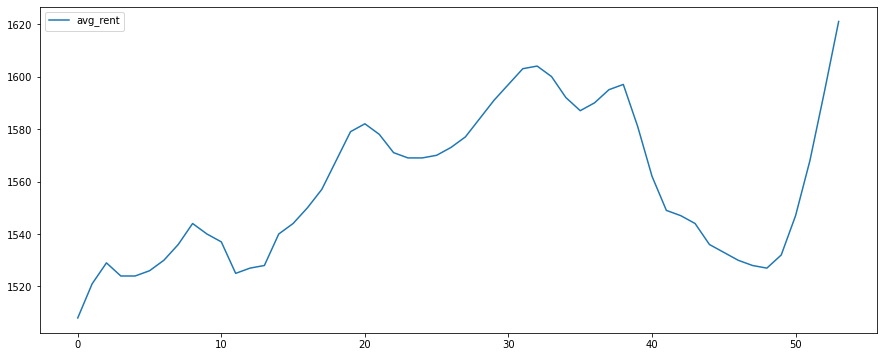

In [6]:
record.plot(figsize=(15, 6))


## Model Selection

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [8]:
results_list = []
param_list = []
seasonal_param_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        param_list.append(param)
        seasonal_param_list.append(param_seasonal)
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            results_list.append(results.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:931.7531492522497
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:680.022092347823
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:420.9584069161699
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1100.5036184477613
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:431.5078884660696
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:413.6178456345466
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:313.41672173990185
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1045.1478536093753
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:917.3007215915889
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:615.6250373128447
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:367.76829421592595
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1832.4168327902203
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:386.157600503271
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:361.75600199967624
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:280.2230369668255
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1812.9869811844658
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:378.7921277516308
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:296.3324872023138
ARIMA

In [9]:
results_df = pd.DataFrame({'param':param_list
              , 'seasonal_param':seasonal_param_list
              , 'aic':results_list})
min_aic = results_df['aic'].min()
results_df

,param,seasonal_param,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",931.753149
1,"(0, 0, 0)","(0, 0, 1, 12)",680.022092
2,"(0, 0, 0)","(0, 1, 0, 12)",420.958407
3,"(0, 0, 0)","(0, 1, 1, 12)",1100.503618
4,"(0, 0, 0)","(1, 0, 0, 12)",431.507888
5,"(0, 0, 0)","(1, 0, 1, 12)",413.617846
6,"(0, 0, 0)","(1, 1, 0, 12)",313.416722
7,"(0, 0, 0)","(1, 1, 1, 12)",1045.147854
8,"(0, 0, 1)","(0, 0, 0, 12)",917.300722
9,"(0, 0, 1)","(0, 0, 1, 12)",615.625037


In [10]:
final_param = results_df.loc[results_df['aic'] == min_aic]['param'].values[0]
final_seasonal = results_df.loc[results_df['aic'] == min_aic]['seasonal_param'].values[0]


results_df.loc[results_df['aic'] == min_aic]

,param,seasonal_param,aic
63,"(1, 1, 1)","(1, 1, 1, 12)",175.902143


## Fit Final Model

In [11]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=final_param,
                                seasonal_order=final_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8265      0.166      4.974      0.000       0.501       1.152
ma.L1          0.4909      0.292      1.679      0.093      -0.082       1.064
ar.S.L12      -0.2788      0.230     -1.214      0.225      -0.729       0.171
ma.S.L12      -1.0000   1.39e+04   -7.2e-05      1.000   -2.72e+04    2.72e+04
sigma2        16.5533    2.3e+05    7.2e-05      1.000    -4.5e+05     4.5e+05


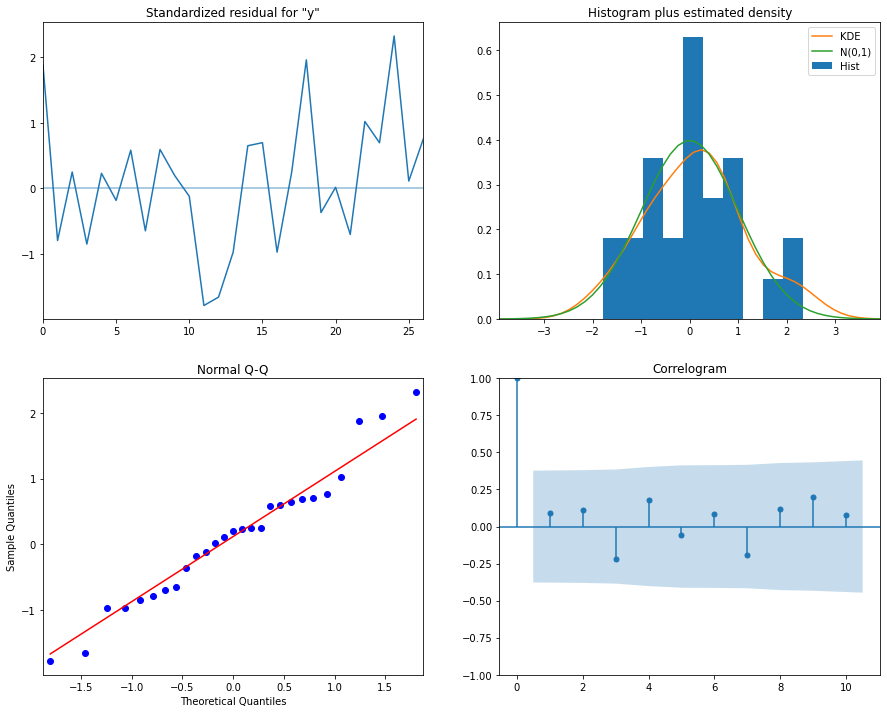

In [13]:
results.plot_diagnostics(figsize=(15, 12))
plt.show() # for some reason if I don't add this it doubles